In [1]:
from Network.DAN import Dan
import tensorflow as tf
import numpy as np
import pandas as pd
from Util import textcnn_util, dgm_utils
import parmas as par
import time
import nnst.nnst as nnst
import datetime

import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


Instructions for updating:
Use the retry module or similar alternatives.


In [2]:
ckpt_name = '../ckpt/dan_'+str(datetime.datetime.now().isoformat())+'.ckpt'

sess = tf.Session()

model = Dan.DAN(
        sess=sess,
        input_shape=[par.max_length, par.embedding_dim],
        learning_rate=par.learning_rate,
        num_classes=par.num_classes,
)

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.

P_var: 
[<tf.Variable 'Predictor_conv_var/window_conv_0/kernel:0' shape=(3, 400, 100) dtype=float32_ref>,
 <tf.Variable 'Predictor_conv_var/window_conv_0/bias:0' shape=(100,) dtype=float32_ref>,
 <tf.Variable 'Predictor_conv_var/BatchNorm/beta:0' shape=(100,) dtype=float32_ref>,
 <tf.Variable 'Predictor_conv_var/BatchNorm/moving_mean:0' shape=(100,) dtype=float32_ref>,
 <tf.Variable 'Predictor_conv_var/BatchNorm/moving_variance:0' shape=(100,) dtype=float32_ref>,
 <tf.Variable 'Predictor_conv_var/window_conv_1/kernel:0' shape=(4, 400, 100) dtype=float32_ref>,
 <tf.Variable 'Predictor_conv_var/window_conv_1/bias:0' shape=(100,) dtype=float32_ref>,
 <tf.Variable 'Predictor_conv_var/BatchNorm_1/beta:0' shape=(100,) dtype=

In [3]:
w2v_model = '../w2v_model/nnst.model'
saver = tf.train.Saver(tf.global_variables())

data = nnst.load_data('../csv/nnst_news.csv')
labeled_set, unlabeled_set = nnst.div_dataset(data, 1500)

In [4]:
labeled_x = textcnn_util.proccessing_util(w2v_model).preprossessing(labeled_set[:,0],par.embedding_dim,par.max_length)
labeled_y = labeled_set[:,1].astype(int)

unlabeled_x = textcnn_util.proccessing_util(w2v_model).preprossessing(unlabeled_set[:,0],par.embedding_dim,par.max_length)
unlabeled_y = unlabeled_set[:,1].astype(int)


test_x = labeled_x[:500]
test_y = labeled_y[:500]


labeled_x = labeled_x[500:]
labeled_y = labeled_y[500:]

/usr/local/lib/python3.6/site-packages/konlpy/tag/_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


In [5]:
print('unlabeled : {}, labeled: {}'.format(len(unlabeled_x), len(labeled_y)))

unlabeled : 58500, labeled: 1000


In [6]:
prev_accuracy = 0
g_loss_history = []
d_loss_history = []
evar_accuracy_history = []
for i in range(10000):
        rand_labeled = np.random.randint(labeled_y.shape[0], size=par.batch_size)
        # rand_labeled = list(rand_labeled)
        rand_idx_unlabeled = np.random.randint(unlabeled_x.shape[0], size=par.batch_size)

        # for j in range(10):
        g_loss = 0

        _, d_loss = model.train(
            labeled=(labeled_x[rand_labeled], labeled_y[rand_labeled]),
            unlabeled=unlabeled_x[rand_idx_unlabeled],
            dropout=0.0
        )
        d_loss_history.append(d_loss)
        
        for j in range(10):
            _, g_loss = model.train(unlabeled_x[rand_idx_unlabeled],dropout=0.0)
            rand_idx_unlabeled = np.random.randint(unlabeled_x.shape[0], size=par.batch_size)
        g_loss_history.append(g_loss)
        
        if i%100 == 0:
            print('-----------------')
            accuracy = model.eval((test_x,test_y))
            evar_accuracy_history.append(accuracy)
            print('epoch: {} \n'
                  'train g loss: {} \n'
                  'train d loss {} \n'
                  'eval_accuracy: {}'
                  .format(i,g_loss,d_loss, accuracy))
            print('-----------------')
            if prev_accuracy <= accuracy:
                saver.save(sess, save_path=ckpt_name)
                prev_accuracy = accuracy

-----------------
epoch: 0 
train g loss: 0.2734791338443756 
train d loss 5.664113998413086 
eval_accuracy: 0.202
-----------------
-----------------
epoch: 100 
train g loss: 0.4536375105381012 
train d loss 1.6253600120544434 
eval_accuracy: 0.17
-----------------
-----------------
epoch: 200 
train g loss: 0.1521320939064026 
train d loss 2.4384918212890625 
eval_accuracy: 0.332
-----------------
-----------------
epoch: 300 
train g loss: 0.507701575756073 
train d loss 1.6733120679855347 
eval_accuracy: 0.252
-----------------
-----------------
epoch: 400 
train g loss: 0.3332689702510834 
train d loss 2.3215720653533936 
eval_accuracy: 0.252
-----------------
-----------------
epoch: 500 
train g loss: 0.20608831942081451 
train d loss 2.402784824371338 
eval_accuracy: 0.162
-----------------
-----------------
epoch: 600 
train g loss: 0.4834437966346741 
train d loss 1.6189175844192505 
eval_accuracy: 0.238
-----------------
-----------------
epoch: 700 
train g loss: 0.9063149

-----------------
epoch: 6100 
train g loss: 0.6531761884689331 
train d loss 0.9146646857261658 
eval_accuracy: 0.25
-----------------
-----------------
epoch: 6200 
train g loss: 0.9529238343238831 
train d loss 0.8945393562316895 
eval_accuracy: 0.276
-----------------
-----------------
epoch: 6300 
train g loss: 0.4022935628890991 
train d loss 1.4974615573883057 
eval_accuracy: 0.242
-----------------
-----------------
epoch: 6400 
train g loss: 1.5449916124343872 
train d loss 0.4956815242767334 
eval_accuracy: 0.246
-----------------
-----------------
epoch: 6500 
train g loss: 0.3571213185787201 
train d loss 1.7879818677902222 
eval_accuracy: 0.228
-----------------
-----------------
epoch: 6600 
train g loss: 1.0715725421905518 
train d loss 0.7863227128982544 
eval_accuracy: 0.196
-----------------
-----------------
epoch: 6700 
train g loss: 0.2927898168563843 
train d loss 1.7505015134811401 
eval_accuracy: 0.216
-----------------
-----------------
epoch: 6800 
train g los

KeyboardInterrupt: 

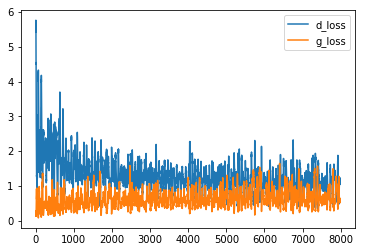

In [7]:
plt.plot(d_loss_history)
plt.plot(g_loss_history)
plt.legend(['d_loss','g_loss'])
plt.show()

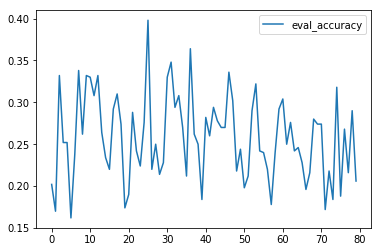

In [8]:
plt.plot(evar_accuracy_history)
plt.legend(['eval_accuracy'])
plt.show()

In [9]:
test_accuracy = model.eval((unlabeled_x,unlabeled_y))
print('test accuracy:', test_accuracy)

test accuracy: 0.2846666666666667
